In [21]:
import numpy as np
import matplotlib.pyplot as plt

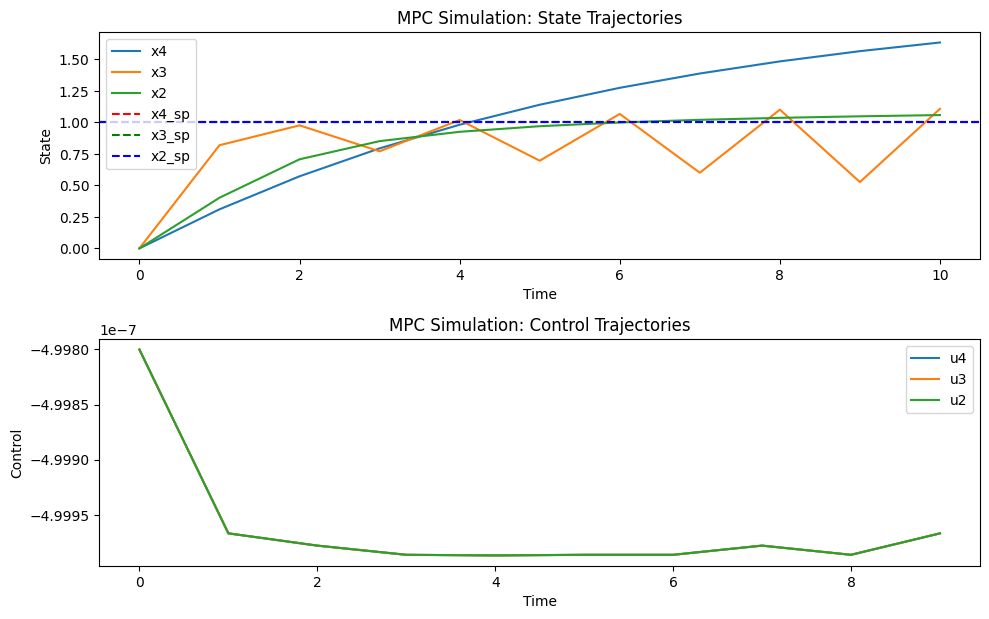

In [22]:
class MPCSimulation:
    def __init__(self):
        self.num_states = 3
        self.num_inputs = 3

        self.Q = np.diag([1.0, 1.0, 1.0])  # State cost matrix
        self.R = np.diag([1.0, 1.0, 1.0])  # Input cost matrix
        self.N = 10  # Control horizon

    def nl_system_model(self, xk, uk):
        """MIMO nonlinear model of the system"""
        x4, x3, x2 = xk
        u4, u3, u2 = uk

        x4_next = 0.310 + 0.846 * x4 + -0.774 * u4 + 0.431 * u4**2 + 0.214 * x4**2 * u4 + -0.199 * x4 * u4**2
        x3_next = 0.819 + 0.891 * x3 + -3.255 * u3 + -0.281 * x3**2 + 0.918 * x3 * u3 + 0.258 * x3 * u2 + \
                  4.028 * u3**2 + -0.698 * x3**3 + 2.582 * x3**2 * u3 + -0.292 * x3**2 * u2 + -2.824 * x3 * u3**2 + -1.512 * u3**3
        x2_next = 0.402 + 1.088 * x2 + -0.724 * u2 + -1.052 * x2**2 + 0.072 * x2 * u2 + 0.583 * x2**3 + \
                  0.793 * x2**2 * u2 + -0.471 * x2 * u2**2 + 0.314 * u2**3

        x_next = np.array([x4_next, x3_next, x2_next])
        y_next = x_next

        return x_next, y_next

    def solve_mpc(self, x0, x_sp):
        """Solves the MPC optimization problem"""
        x = np.zeros((self.N + 1, self.num_states))
        u = np.zeros((self.N, self.num_inputs))

        x[0] = x0

        for i in range(self.N):
            # Obtain the current state and setpoint
            xk = x[i]
            if i < len(x_sp):
                xk_sp = x_sp[i]
            else:
                xk_sp = x_sp[-1]  # Use the last setpoint if available setpoints are exhausted

            # Solve the optimization problem to obtain the control inputs
            uk = self.optimize_control_inputs(xk, xk_sp)

            # Apply the control inputs to the system model
            x_next, _ = self.nl_system_model(xk, uk)

            # Store the results
            x[i + 1] = x_next
            u[i] = uk

        return {'x': x, 'u': u}

    def optimize_control_inputs(self, xk, xk_sp):
        """Performs optimization to find the optimal control inputs"""
        lr = 0.1  # Learning rate
        num_iterations = 100  # Number of optimization iterations

        uk = np.zeros(self.num_inputs)  # Initial control inputs

        for _ in range(num_iterations):
            # Compute the gradient of the cost function with respect to the control inputs
            gradient = self.compute_cost_gradient(xk, uk, xk_sp)

            # Update the control inputs using gradient descent
            uk -= lr * gradient

        return uk

    def compute_cost_gradient(self, xk, uk, xk_sp):
        """Computes the gradient of the cost function with respect to the control inputs"""
        eps = 1e-6  # Small value for numerical differentiation

        gradient = np.zeros(self.num_inputs)

        for i in range(self.num_inputs):
            # Perturb the control input
            uk_perturbed = np.copy(uk)
            uk_perturbed[i] += eps

            # Compute the cost function for the perturbed control input
            cost_perturbed = self.compute_cost(xk, uk_perturbed, xk_sp)

            # Compute the partial derivative using central difference approximation
            gradient[i] = (cost_perturbed - self.compute_cost(xk, uk, xk_sp)) / eps

        return gradient

    def compute_cost(self, xk, uk, xk_sp):
        """Computes the cost function based on the current state, control inputs, and setpoint"""
        cost = 0.5 * ((xk - xk_sp) @ self.Q @ (xk - xk_sp) + uk @ self.R @ uk)
        return cost

    def simulate(self):
        x0 = np.array([0.0, 0.0, 0.0])  # Initial state
        x_sp = np.array([1.0, 1.0, 1.0])  # Setpoint

        result = self.solve_mpc(x0, x_sp)

        # Extract the simulation results
        x = result["x"]
        u = result["u"]

        # Plotting the results
        t = np.arange(self.N + 1)

        plt.figure(figsize=(10, 12))

        plt.subplot(4, 1, 1)
        plt.plot(t, x[:, 0], label="x4")
        plt.plot(t, x[:, 1], label="x3")
        plt.plot(t, x[:, 2], label="x2")
        plt.axhline(y=x_sp[0], color="r", linestyle="--", label="x4_sp")
        plt.axhline(y=x_sp[1], color="g", linestyle="--", label="x3_sp")
        plt.axhline(y=x_sp[2], color="b", linestyle="--", label="x2_sp")
        plt.xlabel("Time")
        plt.ylabel("State")
        plt.title("MPC Simulation: State Trajectories")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(t[:-1], u[:, 0], label="u4")
        plt.plot(t[:-1], u[:, 1], label="u3")
        plt.plot(t[:-1], u[:, 2], label='u2')
        plt.xlabel('Time')
        plt.ylabel('Control')
        plt.title('MPC Simulation: Control Trajectories')
        plt.legend()


        plt.tight_layout()
        plt.show()

simulation = MPCSimulation()
simulation.simulate()